## Neural Network Training

This file is for training a standard neural network architecture for binary classification

##### 0. Imports

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split

##### 1. Load dataset

In [2]:
data = torch.load('data.pt')
features = data['features']
labels = data['labels']

In [3]:
print('Features shape:', features.shape)
print('Labels shape:', labels.shape)

Features shape: torch.Size([939, 60660])
Labels shape: torch.Size([939])


##### 2. Data scaling

Log transform - squashes large gene counts so that they don't dominate

In [4]:
features = np.log1p(features)

C:\Users\SBC98\AppData\Local\Temp\ipykernel_12044\266357826.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  features = np.log1p(features)


Standard scalar - recenters the vectors around 0

In [5]:
scaler = StandardScaler().fit(features)
features = scaler.transform(features) 

##### 3. Dimensionality reduction

Principle Component Analysis

In [6]:
n_components = 100
pca = PCA(n_components=n_components, random_state=42)
features = pca.fit_transform(features)

##### 2. Create Torch dataset object

In [7]:
class BinaryDataset(Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Check tensor data type

In [8]:
if not isinstance(features, torch.Tensor):
    features = torch.tensor(features, dtype=torch.float32)
else:
    features = features.float()

if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels, dtype=torch.float32)
else:
    labels = labels.float()

##### 3. Split train and test

In [9]:
dataset = BinaryDataset(features, labels)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

##### 4. Define Torch dataloaders

In [10]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

##### 5. Define the model

In [59]:
class Network(nn.Module):
    def __init__(self, input_dim):
        super(Network, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 248),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(248, 124),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(124, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Network(input_dim=features.shape[1]).to(device)

##### 6. Set loss and optimizer

In [61]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

##### 7. Train

In [62]:
num_epochs = 25
train_losses = []
trn_accuracies, val_accuracies = [], []
for epoch in range(num_epochs):
    
    # Train over all batches of the train set
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)

    # Save the model loss for this epoch
    avg_loss = total_loss / train_size
    train_losses.append(avg_loss)
    print(f"--> Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Get model the model accuracies for this epoch
    model.eval()
    trn_correct, trn_total = 0, 0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        
        # Train set
        for X_trn, y_trn in train_loader:
            X_trn, y_trn = X_trn.to(device), y_trn.to(device).unsqueeze(1)
            preds = (model(X_trn) > 0.5).float()
            trn_correct += (preds == y_trn).sum().item()
            trn_total += y_trn.size(0)
        
        # Test set
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device).unsqueeze(1)
            preds = (model(X_val) > 0.5).float()
            val_correct += (preds == y_val).sum().item()
            val_total += y_val.size(0)
    
    trn_acc = trn_correct / trn_total
    val_acc = val_correct / val_total
    
    trn_accuracies.append(trn_acc)
    val_accuracies.append(val_acc)
    
    print(f"Train Accuracy: {trn_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")

--> Epoch 1/25, Loss: 1.0626
Train Accuracy: 0.7519
Validation Accuracy: 0.7553
--> Epoch 2/25, Loss: 0.9494
Train Accuracy: 0.8082
Validation Accuracy: 0.8085
--> Epoch 3/25, Loss: 1.0391
Train Accuracy: 0.8265
Validation Accuracy: 0.8121
--> Epoch 4/25, Loss: 0.7004
Train Accuracy: 0.8250
Validation Accuracy: 0.8262
--> Epoch 5/25, Loss: 0.6504
Train Accuracy: 0.8295
Validation Accuracy: 0.8262
--> Epoch 6/25, Loss: 0.6522
Train Accuracy: 0.8311
Validation Accuracy: 0.8333
--> Epoch 7/25, Loss: 0.6285
Train Accuracy: 0.8326
Validation Accuracy: 0.8333
--> Epoch 8/25, Loss: 0.7464
Train Accuracy: 0.8356
Validation Accuracy: 0.8369
--> Epoch 9/25, Loss: 0.5564
Train Accuracy: 0.8387
Validation Accuracy: 0.8298
--> Epoch 10/25, Loss: 0.7004
Train Accuracy: 0.8387
Validation Accuracy: 0.8121
--> Epoch 11/25, Loss: 0.5674
Train Accuracy: 0.8387
Validation Accuracy: 0.8156
--> Epoch 12/25, Loss: 0.6150
Train Accuracy: 0.8463
Validation Accuracy: 0.8085
--> Epoch 13/25, Loss: 0.4646
Train A

##### 5. Evaluate

Plot the loss curve

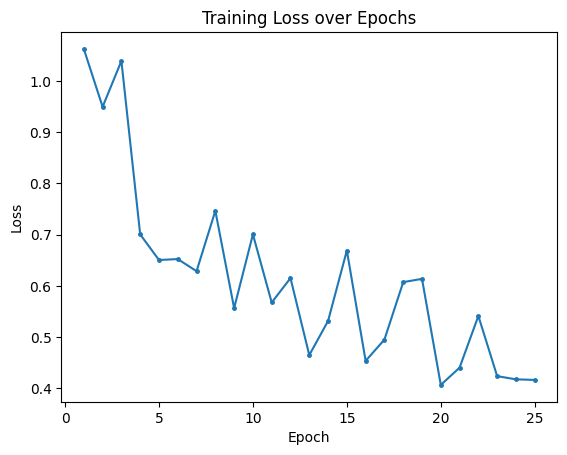

In [63]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, marker='o', ms=2.5)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Plot the validation accuracy curve

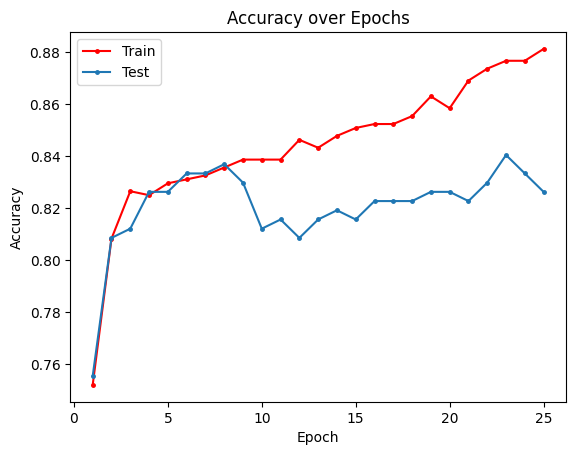

In [64]:
plt.figure()
plt.plot(range(1, num_epochs+1), trn_accuracies, marker='o', label='Train', color='red', ms=2.5)
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o', label='Test', ms=2.5)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()